### PUC Minas
### Pós-graduação em Ciência de Dados e Big Data
### Trabalho de Conclusão de Curso

# Prevendo Desastres Naturais com Dados Meteorológicos e Machine Learning

### Aluno: Renan Kinetz Wachter

Este notebook trata dados de alertas de desastres naturais atrelados a condições meteorológicas e utiliza modelos de machine learning para tentar prever desastres com base nas medições do clima. Foram selecionados três algoritmos de aprendizado supervisionado que serão comparados para entender qual possui melhor performance.

Os dados de desastres naturais foram obtidos do dataset de notificações de alertas de desastres da Anatel. Estes alertas são normalmente enviados por SMS a moradores de regiões que correm riscos devido às condições climáticas no momento. Para este trabalho, serão considerados somente os alertas relacionados às chuvas, como deslizamentos e enchentes, por exemplo.

Já os dados de estações meteorológicas foram obtidos através do Instituto Nacional de Meteorologia, e contém a medição de hora em hora dos principais indicadores do clima, como temperatura, precipitação e umidade. Foram selecionadas três cidades do estado de Santa Catarina para a análise: Florianópolis, Laguna e Itajaí.

In [ ]:
# Importação de bibliotecas
!pip install mlxtend

In [79]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.plotting import plot_decision_regions
import seaborn as sns
import numpy as np
import pandas as pd
import os

pd.options.mode.chained_assignment = None  # default='warn'

In [5]:
# Raiz do diretório dos arquivos
raiz = r"\Pós\TCC"
raiz = r"C:\Users\renan\Documents\Estudos\Pós\TCC"

# 1. Coleta e preparação dos dados

## 1.1. Dataset Anatel: Notificações de Alertas de Desastres
Disponível em: https://dados.gov.br/dados/conjuntos-dados/anatel-utilidade-publica

Link direto: https://www.anatel.gov.br/dadosabertos/paineis_de_dados/utilidade_publica/notificacoes_alertas.zip

Acesso em: 18/12/2022

In [6]:
csv_anatel = r"\notificacoes_alertas\notificacoes_alertas_tabela.csv"

In [7]:
df_anatel = pd.read_csv(raiz + csv_anatel, sep=";")

In [8]:
df_anatel.head()

,Forma de Envio,Data,Código do Alerta,Mensagem,Tipo de Alerta,Município,Código IBGE,UF,-
0,SMS,18/03/2019 18:45:21,11119/2019,"Defesa Civil: 18:43 Chuva intensa em Jau, Dour...",CHUVAS INTENSAS,Ibaté (SP),3519303,SP,NaN
1,SMS,19/03/2022 13:29:12,5499/2022,Defesa Civil:13:25-Chuva intensa entre Araraqu...,CHUVAS INTENSAS,Ibaté (SP),3519303,SP,NaN
2,SMS,18/02/2020 17:44:33,4663/2020,Defesa Civil:17:44 Chuva intensa em Sao Carlos...,CHUVAS INTENSAS,Ibaté (SP),3519303,SP,NaN
3,SMS,13/04/2019 19:30:39,11779/2019,Defesa Civil: 19h29 Chuvas intensas em Araraqu...,CHUVAS INTENSAS,Ibaté (SP),3519303,SP,NaN
4,SMS,09/11/2021 16:44:04,16086/2021,Defesa Civil:16:40 Chuva intensa em Guatapara ...,CHUVAS INTENSAS,Ibaté (SP),3519303,SP,NaN


Análise inicial do dataset: padronizando nomes das colunas e ajustando tipo da coluna de data

In [9]:
# Renomeando colunas
columns = {"Forma de Envio": "forma_envio",
           "Data": "data_envio",
           "Código do Alerta": "codigo_alerta",
           "Mensagem": "mensagem",
           "Tipo de Alerta": "tipo_alerta",
           "Município": "cidade",
           "Código IBGE": "codigo_ibge",
           "UF": "uf"}

df_anatel = df_anatel.rename(columns=columns)

In [10]:
# Tipos das colunas
df_anatel.dtypes

forma_envio       object
data_envio        object
codigo_alerta     object
mensagem          object
tipo_alerta       object
cidade            object
codigo_ibge        int64
uf                object
-                float64
dtype: object

In [11]:
# Alterando tipo da coluna data_envio de string para datetime
format = "%d/%m/%Y %H:%M:%S"

df_anatel['data_envio'] = pd.to_datetime(df_anatel['data_envio'], format=format)

df_anatel.dtypes

forma_envio              object
data_envio       datetime64[ns]
codigo_alerta            object
mensagem                 object
tipo_alerta              object
cidade                   object
codigo_ibge               int64
uf                       object
-                       float64
dtype: object

Gerando ranking de quantidade de alertas por estado

In [12]:
# Ranking de alertas por UF
df_anatel.groupby(["uf"]).size().sort_values(ascending=False)

uf
SP    285195
SC    191641
PR    158557
MG    118357
GO    116635
RS     88944
RJ     30646
MS     26867
MT     15121
BA     11072
SE      8849
PA      4151
AL      4051
ES      3745
RN       924
RO       552
DF       408
CE       119
PE       118
PB        42
AM        22
TO        10
RR         5
dtype: int64

Geramos uma lista com os tipos de alertas mais acionados em Santa Catarina para entender quais poderiam ser retirados (por falta de relação com o tempo/clima) ou agrupados

In [13]:
# Novo dataframe com alertas de Santa Catarina
df_sc = df_anatel[df_anatel["uf"] == "SC"]

df_sc["tipo_alerta"] = df_sc["tipo_alerta"].str[:100]

df_sc.groupby(["tipo_alerta"]).size().sort_values(ascending=False)

tipo_alerta
CHUVAS INTENSAS                                      121136
TEMPESTADE LOCAL/CONVECTIVA - CHUVAS INTENSAS         17969
VENDAVAL                                              12599
DOENÇAS INFECCIOSAS VIRAIS                             7839
TEMPESTADE LOCAL/CONVECTIVA - GRANIZO                  6623
DESLIZAMENTOS                                          4923
ALAGAMENTOS                                            4207
ONDA DE FRIO - FRIAGEM                                 3336
GRANIZO                                                3068
ONDA DE FRIO - GEADAS                                  2381
ONDA DE CALOR                                          1783
TEMPESTADE LOCAL/CONVECTIVA - TEMPESTADE DE RAIOS      1248
ENXURRADAS                                             1147
INUNDAÇÕES                                             1132
CICLONES - MARÉS DE TEMPESTADE (RESSACAS)               939
TEMPESTADE LOCAL/CONVECTIVA - VENDAVAL                  696
TORNADO                     

São criadas duas listas: a primeira com os tipos de alertas que serão desconsiderados e a segunda com o mapeamento para os novos nomes de alertas

In [14]:
# Padronizando e removendo alertas irrelevantes para a pesquisa
alertas_excluidos = ["DOENÇAS INFECCIOSAS VIRAIS", "ONDA DE FRIO - FRIAGEM",
                     "ONDA DE FRIO - GEADAS", "ONDA DE CALOR", "TRANSPORTE DE PRODUTOS PERIGOSOS AÉREO"]

alertas_renomeados = {"CHUVAS INTENSAS" : "CHUVAS INTENSAS",
                      "TEMPESTADE LOCAL/CONVECTIVA - TEMPESTADE DE RAIOS": "CHUVAS INTENSAS",
                      "TEMPESTADE LOCAL/CONVECTIVA - CHUVAS INTENSAS"    : "CHUVAS INTENSAS",
                      "VENDAVAL"                                         : "VENDAVAL",
                      "TEMPESTADE LOCAL/CONVECTIVA - VENDAVAL"           : "VENDAVAL",
                      "GRANIZO"                                          : "GRANIZO",
                      "TEMPESTADE LOCAL/CONVECTIVA - GRANIZO"            : "GRANIZO",
                      "DESLIZAMENTOS"                                    : "DESLIZAMENTOS",
                      "ALAGAMENTOS"                                      : "ALAGAMENTOS",
                      "ENXURRADAS"                                       : "ENXURRADAS",
                      "INUNDAÇÕES"                                       : "INUNDAÇÕES",
                      "CICLONES - MARÉS DE TEMPESTADE (RESSACAS)"        : "CICLONE",
                      "CICLONES - VENTOS COSTEIROS (MOBILIDADE DE DUNAS)": "CICLONE",
                      "TORNADO"                                          : "TORNADO",
                      "TEMPESTADE LOCAL/CONVECTIVA - TORNADOS"           : "TORNADO"}

df_sc = df_sc[~df_sc['tipo_alerta'].isin(alertas_excluidos)]
df_sc['tipo_alerta'] = df_sc['tipo_alerta'].map(alertas_renomeados)

df_sc.groupby(["tipo_alerta"]).size().sort_values(ascending=False)

tipo_alerta
CHUVAS INTENSAS    140353
VENDAVAL            13295
GRANIZO              9691
DESLIZAMENTOS        4923
ALAGAMENTOS          4207
ENXURRADAS           1147
INUNDAÇÕES           1132
CICLONE               956
TORNADO               129
dtype: int64

Novo dataframe é criado com as 3 cidades catarinenses com maior população e que possuem dados das estações meteorológicas

In [15]:
# Novo dataframe com top 3 cidades de SC
cidades = ["Florianópolis (SC)", "Laguna (SC)", "Itajaí (SC)"]

df_cidades = df_sc[df_sc['cidade'].isin(cidades)]

map_cidades = {"Florianópolis (SC)": "florianopolis",
               "Laguna (SC)"       : "laguna",
               "Itajaí (SC)"       : "itajai"}

df_cidades["cidade"] = df_cidades["cidade"].map(map_cidades)

df_anatel_final = df_cidades.drop(columns=["-", "forma_envio", "mensagem", "codigo_ibge", "uf", "codigo_alerta"])

São removidas colunas sem necessidade, seja por redundância ou irrelevância ao modelo.

Vale ressaltar que, como os dados já estão classificados por tipo de alerta, não faz-se necessária a mineração de texto da coluna "mensagem" pois criaria um resultado potencialmente redundante.

In [16]:
df_anatel_final

,data_envio,tipo_alerta,cidade
889376,2022-05-17 08:19:47,VENDAVAL,laguna
889377,2018-12-21 14:52:17,CHUVAS INTENSAS,laguna
889378,2022-07-11 10:32:52,VENDAVAL,laguna
889379,2021-02-28 04:18:07,CHUVAS INTENSAS,laguna
889382,2018-03-25 19:20:19,VENDAVAL,laguna
...,...,...,...
920603,2022-07-11 11:09:46,GRANIZO,itajai
920604,2022-08-10 08:56:31,CHUVAS INTENSAS,itajai
920605,2019-01-18 20:25:19,CHUVAS INTENSAS,itajai
920606,2022-03-29 14:04:19,CICLONE,itajai


Identificando as datas mínimas e máximas de envio dos alertas de desastres para delimitar qual período coletar do Instituto Nacional de Meteorologia

In [17]:
df_anatel_final.describe(datetime_is_numeric=True)

,data_envio
count,2116
mean,2020-05-15 22:35:20.305292800
min,2017-11-10 12:54:02
25%,2018-11-28 08:58:43
50%,2020-07-01 09:52:31
75%,2021-10-29 14:22:03.500000
max,2022-12-05 11:57:24


In [18]:
df_anatel_final_bkp = df_anatel_final.copy()

## 1.2. Dataset Instituto Nacional de Meteorologia: Dados Históricos Anuais
Disponível em: https://portal.inmet.gov.br/dadoshistoricos

Links diretos:
- https://portal.inmet.gov.br/uploads/dadoshistoricos/2017.zip
- https://portal.inmet.gov.br/uploads/dadoshistoricos/2018.zip
- https://portal.inmet.gov.br/uploads/dadoshistoricos/2019.zip
- https://portal.inmet.gov.br/uploads/dadoshistoricos/2020.zip
- https://portal.inmet.gov.br/uploads/dadoshistoricos/2021.zip
- https://portal.inmet.gov.br/uploads/dadoshistoricos/2022.zip

Acesso em: 14/12/2022


Os relatórios de meteorologia estão separados por ano e cidade. Será importante analisar, antes de unificá-los, se estão todos no mesmo padrão.

Listamos os arquivos CSV presentes no diretório para transformamos em um dataframe

In [19]:
# Listando os arquivos
dir_csv_inm = "\\inm_historico\sc\\"

lista_csv_inm = os.listdir(raiz + dir_csv_inm)

lista_csv_inm

['INMET_S_SC_A806_FLORIANOPOLIS_01-01-2017_A_31-12-2017.CSV',
 'INMET_S_SC_A806_FLORIANOPOLIS_01-01-2018_A_31-12-2018.CSV',
 'INMET_S_SC_A806_FLORIANOPOLIS_01-01-2019_A_31-12-2019.CSV',
 'INMET_S_SC_A806_FLORIANOPOLIS_01-01-2020_A_31-12-2020.CSV',
 'INMET_S_SC_A806_FLORIANOPOLIS_01-01-2021_A_31-12-2021.CSV',
 'INMET_S_SC_A806_FLORIANOPOLIS_01-01-2022_A_31-10-2022.CSV',
 'INMET_S_SC_A866_Laguna  - Farol de Santa Marta_01-01-2017_A_31-12-2017.CSV',
 'INMET_S_SC_A866_Laguna  - Farol de Santa Marta_01-01-2018_A_31-12-2018.CSV',
 'INMET_S_SC_A866_Laguna  - Farol de Santa Marta_01-01-2019_A_31-12-2019.CSV',
 'INMET_S_SC_A866_Laguna  - Farol de Santa Marta_01-01-2020_A_31-12-2020.CSV',
 'INMET_S_SC_A866_Laguna  - Farol de Santa Marta_01-01-2021_A_31-12-2021.CSV',
 'INMET_S_SC_A866_Laguna  - Farol de Santa Marta_01-01-2022_A_31-10-2022.CSV',
 'INMET_S_SC_A868_ITAJAI_01-01-2017_A_31-12-2017.CSV',
 'INMET_S_SC_A868_ITAJAI_01-01-2018_A_31-12-2018.CSV',
 'INMET_S_SC_A868_ITAJAI_01-01-2019_A_31-12-

Os arquivos possuem outras informações antes do header com os nomes das colunas, portanto, retiraremos essas linhas dos CSVs

In [20]:
# Exemplo de header irregular dos arquivos

header_irr = open(raiz + dir_csv_inm + lista_csv_inm[0]).readlines()[:10]

print(header_irr)

['REGIÃO:;CO\n', 'UF:;DF\n', 'ESTAÇÃO:;BRASILIA\n', 'CODIGO (WMO):;A001\n', 'LATITUDE:;-15,78944444\n', 'LONGITUDE:;-47,92583332\n', 'ALTITUDE:;1159,54\n', 'DATA DE FUNDAÇÃO (YYYY-MM-DD):;2000-05-07\n', 'DATA (YYYY-MM-DD);HORA (UTC);PRECIPITAÇÃO TOTAL, HORÁRIO (mm);PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB);PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB);PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB);RADIACAO GLOBAL (KJ/m²);TEMPERATURA DO AR - BULBO SECO, HORARIA (°C);TEMPERATURA DO PONTO DE ORVALHO (°C);TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C);TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C);TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C);TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C);UMIDADE REL. MAX. NA HORA ANT. (AUT) (%);UMIDADE REL. MIN. NA HORA ANT. (AUT) (%);UMIDADE RELATIVA DO AR, HORARIA (%);VENTO, DIREÇÃO HORARIA (gr) (° (gr));VENTO, RAJADA MAXIMA (m/s);VENTO, VELOCIDADE HORARIA (m/s);\n', '2017-01-01;00:00;0;887,6;887,6;887;-9999;22;13,9;23,2;21,8;14;12,8;61;52;

In [20]:
# Removendo header irregular

for csv in lista_csv_inm:
    
    arquivo = raiz + dir_csv_inm + csv

    with open(arquivo, 'r+') as file:

        lines = file.readlines()
        
#         file.seek(0)
#         file.truncate()

#         file.writelines(lines[8:])
        
        file.close()

Os dataframes são unificados e observa-se a necessidade de padronizar algumas colunas que possuem nomes diferentes em alguns arquivos

In [21]:
lista_dfs = []

for csv in lista_csv_inm:
    df = pd.read_csv(raiz + dir_csv_inm + csv, sep=';', encoding="ISO-8859-1")
    df['cidade'] = csv
    lista_dfs.append(df)
    
df_unificado = pd.concat(lista_dfs)

In [22]:
df_unificado

,DATA (YYYY-MM-DD),HORA (UTC),"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (KJ/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),...,UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",Unnamed: 19,cidade,Data,Hora UTC,RADIACAO GLOBAL (Kj/m²)
0,2017-01-01,00:00,"1,4",1011,1011,"1009,7",-9999,"23,5","21,7",24,...,89.0,89.0,291.0,"7,9","3,6",NaN,INMET_S_SC_A806_FLORIANOPOLIS_01-01-2017_A_31-...,NaN,NaN,NaN
1,2017-01-01,01:00,"1,8","1011,4","1011,4","1010,7",-9999,"23,2","21,5","23,6",...,89.0,91.0,282.0,7,"2,5",NaN,INMET_S_SC_A806_FLORIANOPOLIS_01-01-2017_A_31-...,NaN,NaN,NaN
2,2017-01-01,02:00,",8","1010,1","1011,4","1010,1",-9999,"23,5","21,7","23,6",...,90.0,90.0,323.0,"5,1",",6",NaN,INMET_S_SC_A806_FLORIANOPOLIS_01-01-2017_A_31-...,NaN,NaN,NaN
3,2017-01-01,03:00,0,"1009,5","1010,2","1009,5",-9999,"23,2","21,3","23,6",...,89.0,89.0,258.0,"3,7","1,9",NaN,INMET_S_SC_A806_FLORIANOPOLIS_01-01-2017_A_31-...,NaN,NaN,NaN
4,2017-01-01,04:00,0,1009,"1009,5","1008,9",-9999,"23,3","21,2","23,3",...,88.0,88.0,309.0,4,"1,3",NaN,INMET_S_SC_A806_FLORIANOPOLIS_01-01-2017_A_31-...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7291,NaN,NaN,0,"1008,7","1008,7","1007,8",NaN,"21,9",17,22,...,74.0,74.0,164.0,"9,2",4,NaN,INMET_S_SC_A868_ITAJAI_01-01-2022_A_31-10-2022...,2022/10/31,1900 UTC,"362,4"
7292,NaN,NaN,0,"1009,6","1009,6","1008,7",NaN,"21,4","15,6","21,9",...,69.0,69.0,170.0,"9,2","3,8",NaN,INMET_S_SC_A868_ITAJAI_01-01-2022_A_31-10-2022...,2022/10/31,2000 UTC,"183,5"
7293,NaN,NaN,0,"1011,3","1011,3","1009,6",NaN,21,"14,7","21,4",...,67.0,67.0,182.0,"8,4",4,NaN,INMET_S_SC_A868_ITAJAI_01-01-2022_A_31-10-2022...,2022/10/31,2100 UTC,"11,5"
7294,NaN,NaN,0,1013,1013,"1011,3",NaN,"20,6",14,21,...,66.0,66.0,164.0,"10,4","3,8",NaN,INMET_S_SC_A868_ITAJAI_01-01-2022_A_31-10-2022...,2022/10/31,2200 UTC,NaN


As colunas de data, hora e radiação precisam ser unificadas

In [23]:
df_unificado[["DATA (YYYY-MM-DD)", "Data", "HORA (UTC)", "Hora UTC", "RADIACAO GLOBAL (KJ/m²)", 
              "RADIACAO GLOBAL (Kj/m²)", "cidade"]]

,DATA (YYYY-MM-DD),Data,HORA (UTC),Hora UTC,RADIACAO GLOBAL (KJ/m²),RADIACAO GLOBAL (Kj/m²),cidade
0,2017-01-01,NaN,00:00,NaN,-9999,NaN,INMET_S_SC_A806_FLORIANOPOLIS_01-01-2017_A_31-...
1,2017-01-01,NaN,01:00,NaN,-9999,NaN,INMET_S_SC_A806_FLORIANOPOLIS_01-01-2017_A_31-...
2,2017-01-01,NaN,02:00,NaN,-9999,NaN,INMET_S_SC_A806_FLORIANOPOLIS_01-01-2017_A_31-...
3,2017-01-01,NaN,03:00,NaN,-9999,NaN,INMET_S_SC_A806_FLORIANOPOLIS_01-01-2017_A_31-...
4,2017-01-01,NaN,04:00,NaN,-9999,NaN,INMET_S_SC_A806_FLORIANOPOLIS_01-01-2017_A_31-...
...,...,...,...,...,...,...,...
7291,NaN,2022/10/31,NaN,1900 UTC,NaN,"362,4",INMET_S_SC_A868_ITAJAI_01-01-2022_A_31-10-2022...
7292,NaN,2022/10/31,NaN,2000 UTC,NaN,"183,5",INMET_S_SC_A868_ITAJAI_01-01-2022_A_31-10-2022...
7293,NaN,2022/10/31,NaN,2100 UTC,NaN,"11,5",INMET_S_SC_A868_ITAJAI_01-01-2022_A_31-10-2022...
7294,NaN,2022/10/31,NaN,2200 UTC,NaN,NaN,INMET_S_SC_A868_ITAJAI_01-01-2022_A_31-10-2022...


In [24]:
df_unificado["Data"] = df_unificado["Data"].str.replace("/", "-")

df_unificado["HORA (UTC)"] = df_unificado["HORA (UTC)"].str[:2]
df_unificado["Hora UTC"] = df_unificado["Hora UTC"].str[:2]

In [25]:
df_unificado["data"] = df_unificado["DATA (YYYY-MM-DD)"].combine_first(df_unificado["Data"])
df_unificado["hora"] = df_unificado["HORA (UTC)"].combine_first(df_unificado["Hora UTC"])
df_unificado["radiacao_global"] = df_unificado["RADIACAO GLOBAL (KJ/m²)"].combine_first(df_unificado["RADIACAO GLOBAL (Kj/m²)"])

df_unificado[["data", "hora", "radiacao_global"]]

df_unificado.replace(",", ".", inplace=True, regex=True)

São criadas as novas colunas de data, hora e radiação com o nome já normalizado

In [26]:
df_unificado

,DATA (YYYY-MM-DD),HORA (UTC),"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (KJ/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),...,"VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",Unnamed: 19,cidade,Data,Hora UTC,RADIACAO GLOBAL (Kj/m²),data,hora,radiacao_global
0,2017-01-01,00,1.4,1011,1011,1009.7,-9999,23.5,21.7,24,...,7.9,3.6,NaN,INMET_S_SC_A806_FLORIANOPOLIS_01-01-2017_A_31-...,NaN,NaN,NaN,2017-01-01,00,-9999
1,2017-01-01,01,1.8,1011.4,1011.4,1010.7,-9999,23.2,21.5,23.6,...,7,2.5,NaN,INMET_S_SC_A806_FLORIANOPOLIS_01-01-2017_A_31-...,NaN,NaN,NaN,2017-01-01,01,-9999
2,2017-01-01,02,.8,1010.1,1011.4,1010.1,-9999,23.5,21.7,23.6,...,5.1,.6,NaN,INMET_S_SC_A806_FLORIANOPOLIS_01-01-2017_A_31-...,NaN,NaN,NaN,2017-01-01,02,-9999
3,2017-01-01,03,0,1009.5,1010.2,1009.5,-9999,23.2,21.3,23.6,...,3.7,1.9,NaN,INMET_S_SC_A806_FLORIANOPOLIS_01-01-2017_A_31-...,NaN,NaN,NaN,2017-01-01,03,-9999
4,2017-01-01,04,0,1009,1009.5,1008.9,-9999,23.3,21.2,23.3,...,4,1.3,NaN,INMET_S_SC_A806_FLORIANOPOLIS_01-01-2017_A_31-...,NaN,NaN,NaN,2017-01-01,04,-9999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7291,NaN,NaN,0,1008.7,1008.7,1007.8,NaN,21.9,17,22,...,9.2,4,NaN,INMET_S_SC_A868_ITAJAI_01-01-2022_A_31-10-2022...,2022-10-31,19,362.4,2022-10-31,19,362.4
7292,NaN,NaN,0,1009.6,1009.6,1008.7,NaN,21.4,15.6,21.9,...,9.2,3.8,NaN,INMET_S_SC_A868_ITAJAI_01-01-2022_A_31-10-2022...,2022-10-31,20,183.5,2022-10-31,20,183.5
7293,NaN,NaN,0,1011.3,1011.3,1009.6,NaN,21,14.7,21.4,...,8.4,4,NaN,INMET_S_SC_A868_ITAJAI_01-01-2022_A_31-10-2022...,2022-10-31,21,11.5,2022-10-31,21,11.5
7294,NaN,NaN,0,1013,1013,1011.3,NaN,20.6,14,21,...,10.4,3.8,NaN,INMET_S_SC_A868_ITAJAI_01-01-2022_A_31-10-2022...,2022-10-31,22,NaN,2022-10-31,22,NaN


São padronizados também os dados da coluna cidade:

In [27]:
df_unificado["cidade"] = df_unificado["cidade"].str.replace(r"[^A-Za-z]", "", regex=True)

df_unificado["cidade"].unique()

array(['INMETSSCAFLORIANOPOLISACSV',
       'INMETSSCALagunaFaroldeSantaMartaACSV', 'INMETSSCAITAJAIACSV'],
      dtype=object)

In [28]:
map_cidades = {"INMETSSCAFLORIANOPOLISACSV":           "florianopolis",
               "INMETSSCALagunaFaroldeSantaMartaACSV": "laguna",
               "INMETSSCAITAJAIACSV":                  "itajai"}

df_unificado["cidade"] = df_unificado["cidade"].map(map_cidades)

df_unificado["cidade"]

0       florianopolis
1       florianopolis
2       florianopolis
3       florianopolis
4       florianopolis
            ...      
7291           itajai
7292           itajai
7293           itajai
7294           itajai
7295           itajai
Name: cidade, Length: 153360, dtype: object

Por fim, as demais colunas também são renomeadas ou excluídas em caso de duplicidade:

In [29]:
columns_drop = ["DATA (YYYY-MM-DD)", "Data", "HORA (UTC)", "Hora UTC",  "RADIACAO GLOBAL (KJ/m²)", 
                "RADIACAO GLOBAL (Kj/m²)", "Unnamed: 19", "radiacao_global", "PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)",
                "PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)", "TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)", 
                "TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)", "TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)",
                "TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)", "UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)",
                "UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)", "VENTO, DIREÇÃO HORARIA (gr) (° (gr))",
                "TEMPERATURA DO PONTO DE ORVALHO (°C)", "VENTO, VELOCIDADE HORARIA (m/s)"]

df_unificado = df_unificado.drop(columns=columns_drop)

columns_rename = {"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)"                     : "precipitacao_mm",
                  "PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)": "pressao_atm",
                  "TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)"         : "temperatura_ar",
                  "UMIDADE RELATIVA DO AR, HORARIA (%)"                  : "umidade_ar",
                  "VENTO, RAJADA MAXIMA (m/s)"                           : "vento_rajada_maxima"}

df_unificado = df_unificado.rename(columns=columns_rename)

In [30]:
df_unificado

,precipitacao_mm,pressao_atm,temperatura_ar,umidade_ar,vento_rajada_maxima,cidade,data,hora
0,1.4,1011,23.5,89.0,7.9,florianopolis,2017-01-01,00
1,1.8,1011.4,23.2,91.0,7,florianopolis,2017-01-01,01
2,.8,1010.1,23.5,90.0,5.1,florianopolis,2017-01-01,02
3,0,1009.5,23.2,89.0,3.7,florianopolis,2017-01-01,03
4,0,1009,23.3,88.0,4,florianopolis,2017-01-01,04
...,...,...,...,...,...,...,...,...
7291,0,1008.7,21.9,74.0,9.2,itajai,2022-10-31,19
7292,0,1009.6,21.4,69.0,9.2,itajai,2022-10-31,20
7293,0,1011.3,21,67.0,8.4,itajai,2022-10-31,21
7294,0,1013,20.6,66.0,10.4,itajai,2022-10-31,22


São alterados os tipos das colunas com medições para float e a coluna de data para datetime

In [31]:
# Tipos das colunas
df_unificado.dtypes

precipitacao_mm         object
pressao_atm             object
temperatura_ar          object
umidade_ar             float64
vento_rajada_maxima     object
cidade                  object
data                    object
hora                    object
dtype: object

In [32]:
map_tipos = {"precipitacao_mm"                     : "float64",
             "pressao_atm"                         : "float64",
             "umidade_ar"                          : "float64",
             "temperatura_ar"                      : "float64",
             "vento_rajada_maxima"                 : "float64",
             "data"                                : "datetime64"}

df_unificado = df_unificado.astype(map_tipos)

df_unificado.dtypes

precipitacao_mm               float64
pressao_atm                   float64
temperatura_ar                float64
umidade_ar                    float64
vento_rajada_maxima           float64
cidade                         object
data                   datetime64[ns]
hora                           object
dtype: object

Observa-se também a existência de linhas com valores nulos, provenientes de arquivos com medições meteorológicas vazias. Opta-se por retirar esses registros:

In [33]:
df_unificado.isna().any()

precipitacao_mm         True
pressao_atm             True
temperatura_ar          True
umidade_ar              True
vento_rajada_maxima     True
cidade                 False
data                   False
hora                   False
dtype: bool

In [34]:
df_unificado.isna().sum()

precipitacao_mm        22907
pressao_atm            22182
temperatura_ar         22184
umidade_ar             23891
vento_rajada_maxima    22197
cidade                     0
data                       0
hora                       0
dtype: int64

In [35]:
df_inm_final = df_unificado.dropna()

df_inm_final

,precipitacao_mm,pressao_atm,temperatura_ar,umidade_ar,vento_rajada_maxima,cidade,data,hora
0,1.4,1011.0,23.5,89.0,7.9,florianopolis,2017-01-01,00
1,1.8,1011.4,23.2,91.0,7.0,florianopolis,2017-01-01,01
2,0.8,1010.1,23.5,90.0,5.1,florianopolis,2017-01-01,02
3,0.0,1009.5,23.2,89.0,3.7,florianopolis,2017-01-01,03
4,0.0,1009.0,23.3,88.0,4.0,florianopolis,2017-01-01,04
...,...,...,...,...,...,...,...,...
7291,0.0,1008.7,21.9,74.0,9.2,itajai,2022-10-31,19
7292,0.0,1009.6,21.4,69.0,9.2,itajai,2022-10-31,20
7293,0.0,1011.3,21.0,67.0,8.4,itajai,2022-10-31,21
7294,0.0,1013.0,20.6,66.0,10.4,itajai,2022-10-31,22


In [36]:
df_inm_bkp = df_inm_final.copy()

## 1.3. Unificação dos datasets

Na etapa de unificação dos datasets de alertas da Anatel e medições meteorológicas do INM, faremos a padronização das colunas de data e também o tratamento de dados ausentes e outliers após a unificação.

In [37]:
# Formato da data hora no dataset da Anatel
df_anatel_final['data_envio']

889376   2022-05-17 08:19:47
889377   2018-12-21 14:52:17
889378   2022-07-11 10:32:52
889379   2021-02-28 04:18:07
889382   2018-03-25 19:20:19
                 ...        
920603   2022-07-11 11:09:46
920604   2022-08-10 08:56:31
920605   2019-01-18 20:25:19
920606   2022-03-29 14:04:19
920608   2021-02-13 22:33:46
Name: data_envio, Length: 2116, dtype: datetime64[ns]

In [38]:
# Formato da data e hora no dataset do INM
df_inm_final[['data', 'hora']]

,data,hora
0,2017-01-01,00
1,2017-01-01,01
2,2017-01-01,02
3,2017-01-01,03
4,2017-01-01,04
...,...,...
7291,2022-10-31,19
7292,2022-10-31,20
7293,2022-10-31,21
7294,2022-10-31,22


Como o dataset no INM não possui segundos nem minutos, padronizaremos as horas no dataset da Anatal para este formato antes de unificar os dados

In [39]:
df_inm_final['data'] = df_inm_final['data'].dt.date.astype(str)

In [40]:
df_anatel_final['data'] = df_anatel_final_bkp['data_envio'].dt.date.astype(str)
df_anatel_final['hora'] = df_anatel_final_bkp['data_envio'].dt.hour.astype(str)

df_anatel_final['hora'] = df_anatel_final['hora'].str.zfill(2)

df_anatel_final = df_anatel_final.drop(columns=['data_envio'])

df_anatel_final[['data', 'hora']]

,data,hora
889376,2022-05-17,08
889377,2018-12-21,14
889378,2022-07-11,10
889379,2021-02-28,04
889382,2018-03-25,19
...,...,...
920603,2022-07-11,11
920604,2022-08-10,08
920605,2019-01-18,20
920606,2022-03-29,14


Unificamos os datasets através de um join por cidade, data e hora do evento. Assim, temos um dataset com medições meteorológicas enriquecido com casos onde tais condições resultaram em um alerta de desastre natural.

In [41]:
df_enriquecido = df_inm_final.merge(df_anatel_final, how='left', on=['cidade', 'data', 'hora'])

In [42]:
df_enriquecido

,precipitacao_mm,pressao_atm,temperatura_ar,umidade_ar,vento_rajada_maxima,cidade,data,hora,tipo_alerta
0,1.4,1011.0,23.5,89.0,7.9,florianopolis,2017-01-01,00,NaN
1,1.8,1011.4,23.2,91.0,7.0,florianopolis,2017-01-01,01,NaN
2,0.8,1010.1,23.5,90.0,5.1,florianopolis,2017-01-01,02,NaN
3,0.0,1009.5,23.2,89.0,3.7,florianopolis,2017-01-01,03,NaN
4,0.0,1009.0,23.3,88.0,4.0,florianopolis,2017-01-01,04,NaN
...,...,...,...,...,...,...,...,...,...
128920,0.0,1008.7,21.9,74.0,9.2,itajai,2022-10-31,19,VENDAVAL
128921,0.0,1009.6,21.4,69.0,9.2,itajai,2022-10-31,20,NaN
128922,0.0,1011.3,21.0,67.0,8.4,itajai,2022-10-31,21,NaN
128923,0.0,1013.0,20.6,66.0,10.4,itajai,2022-10-31,22,NaN


In [43]:
# Quantidade de dados ausentes por coluna
df_enriquecido.isna().sum()

precipitacao_mm             0
pressao_atm                 0
temperatura_ar              0
umidade_ar                  0
vento_rajada_maxima         0
cidade                      0
data                        0
hora                        0
tipo_alerta            127318
dtype: int64

É criado um label denominado "SEM REGISTRO" para medições do clima que não resultaram em alertas. Além disso, para facilitar a leitura dos dados pelos modelos, é criada uma coluna booleana onde True indica que houve um alerta de desastre de qualquer tipo e False indica a ausência de alertas.

In [44]:
# Criação do label 'SEM REGISTRO' para as medições do clima que não resultaram em alertas
df_enriquecido.fillna("SEM REGISTRO", inplace=True)

map_alertas = {'SEM REGISTRO'   : False,
               'CHUVAS INTENSAS': True,
               'VENDAVAL'       : True,
               'ALAGAMENTOS'    : True,
               'DESLIZAMENTOS'  : True,
               'GRANIZO'        : True,
               'CICLONE'        : True,
               'ENXURRADAS'     : True,
               'TORNADO'        : True,
               'INUNDAÇÕES'     : True}

df_enriquecido['alerta_desastre'] = df_enriquecido["tipo_alerta"].map(map_alertas)

df_enriquecido

,precipitacao_mm,pressao_atm,temperatura_ar,umidade_ar,vento_rajada_maxima,cidade,data,hora,tipo_alerta,alerta_desastre
0,1.4,1011.0,23.5,89.0,7.9,florianopolis,2017-01-01,00,SEM REGISTRO,False
1,1.8,1011.4,23.2,91.0,7.0,florianopolis,2017-01-01,01,SEM REGISTRO,False
2,0.8,1010.1,23.5,90.0,5.1,florianopolis,2017-01-01,02,SEM REGISTRO,False
3,0.0,1009.5,23.2,89.0,3.7,florianopolis,2017-01-01,03,SEM REGISTRO,False
4,0.0,1009.0,23.3,88.0,4.0,florianopolis,2017-01-01,04,SEM REGISTRO,False
...,...,...,...,...,...,...,...,...,...,...
128920,0.0,1008.7,21.9,74.0,9.2,itajai,2022-10-31,19,VENDAVAL,True
128921,0.0,1009.6,21.4,69.0,9.2,itajai,2022-10-31,20,SEM REGISTRO,False
128922,0.0,1011.3,21.0,67.0,8.4,itajai,2022-10-31,21,SEM REGISTRO,False
128923,0.0,1013.0,20.6,66.0,10.4,itajai,2022-10-31,22,SEM REGISTRO,False


Agora resta o tratamento de outliers e dados ausentes antes de realizar a análise/exploração de dados.

In [45]:
df_enriquecido.describe()

,precipitacao_mm,pressao_atm,temperatura_ar,umidade_ar,vento_rajada_maxima
count,128925.000000,128925.000000,128925.000000,128925.000000,128925.000000
mean,-292.998619,691.416278,-272.991018,-216.613450,-839.046577
std,1686.868662,1857.965278,1690.350674,1700.181061,2780.764504
min,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000
25%,0.000000,1009.900000,17.700000,71.000000,2.000000
50%,0.000000,1014.000000,20.700000,81.000000,3.900000
75%,0.000000,1018.100000,23.500000,88.000000,6.700000
max,45.000000,1034.700000,39.300000,100.000000,44.900000


Observa-se que todas as colunas possuem registros com erros de medição, indicados pelo valor -9999. Os registros com esses valores incorretos são removidos.

In [46]:
query = 'precipitacao_mm == -9999 or pressao_atm == -9999 or temperatura_ar == -9999 or \
        umidade_ar == -9999 or vento_rajada_maxima == -9999'

index = df_enriquecido.query(query).index

df_enriquecido.drop(index, inplace=True)

df_enriquecido.describe()

,precipitacao_mm,pressao_atm,temperatura_ar,umidade_ar,vento_rajada_maxima
count,118046.000000,118046.000000,118046.000000,118046.000000,118046.000000
mean,0.172189,1014.487380,20.828018,78.848983,5.125469
std,1.100546,5.897097,4.249074,11.581090,3.997162
min,0.000000,990.300000,3.100000,13.000000,0.000000
25%,0.000000,1010.500000,18.100000,72.000000,2.400000
50%,0.000000,1014.300000,21.000000,81.000000,4.300000
75%,0.000000,1018.400000,23.700000,88.000000,6.900000
max,45.000000,1034.700000,39.300000,100.000000,44.900000


In [47]:
df_enriquecido_bkp = df_enriquecido.copy()

# 2. Exploração dos dados

A primeira análise feita é a correlação entre os atributos do dataset. Observa-se no mapa de calor que o máximo observado é a correlação inversa de -0,49 entre a pressão atmosférica e temperatura do ar, seguidos de -0,39 de correlação entre umidade e temperatura do ar. Por mais que sejam os maiores valores observados, não representam correlações consideradas fortes o suficiente.

In [48]:
colunas_correlacao = ['precipitacao_mm', 'pressao_atm', 'temperatura_ar', 'umidade_ar', 'vento_rajada_maxima']

correlacoes = df_enriquecido[colunas_correlacao].corr()

correlacoes

,precipitacao_mm,pressao_atm,temperatura_ar,umidade_ar,vento_rajada_maxima
precipitacao_mm,1.000000,-0.035983,-0.026286,0.143263,0.060858
pressao_atm,-0.035983,1.000000,-0.487212,-0.015865,-0.178317
temperatura_ar,-0.026286,-0.487212,1.000000,-0.367935,0.185477
umidade_ar,0.143263,-0.015865,-0.367935,1.000000,-0.236128
vento_rajada_maxima,0.060858,-0.178317,0.185477,-0.236128,1.000000


<AxesSubplot:>

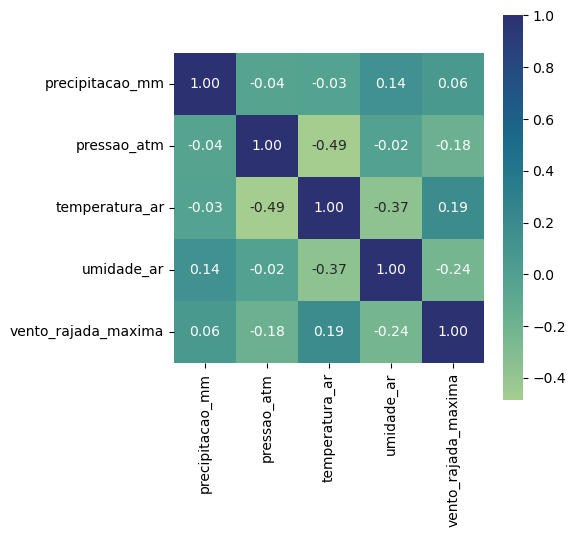

In [49]:
plt.subplots(figsize=(5, 5))
sns.heatmap(correlacoes, annot=True, fmt=".2f", cmap="crest", square=True)

É gerado também um ranking dos tipos de alertas. Como a maior parte do dataset possui medições que não resultaram em alertas, para facilitar a visualização, os plots seguintes foram gerados somente considerando linhas com tipo de alerta diferente de "SEM REGISTRO".

<AxesSubplot:ylabel='tipo_alerta'>

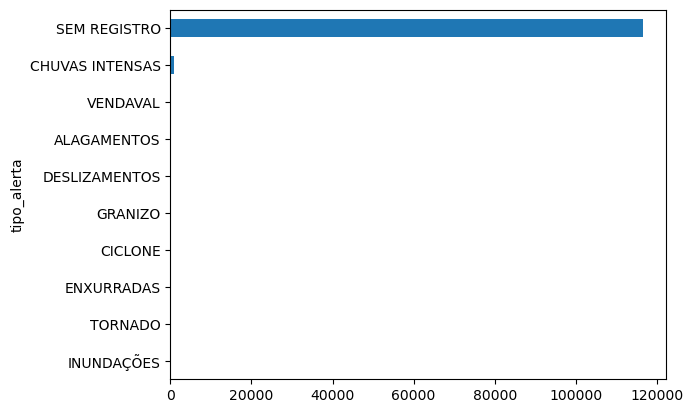

In [50]:
ranking_alertas = df_enriquecido.groupby(['tipo_alerta']).size().sort_values()

ranking_alertas.plot.barh()

A maior parte dos alertas gerados são de chuvas intensas, vendavais e alagamentos.

<AxesSubplot:ylabel='tipo_alerta'>

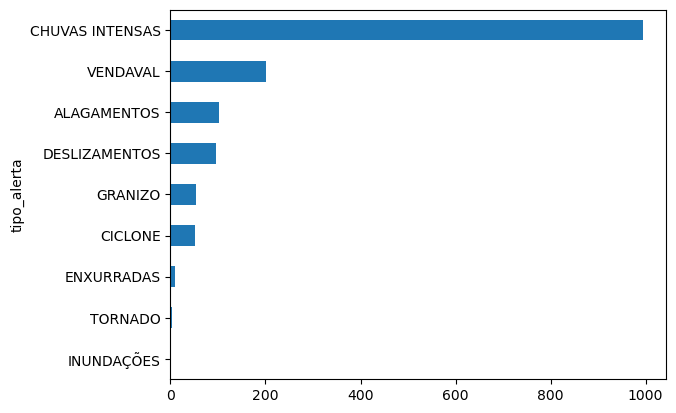

In [51]:
query = 'tipo_alerta != "SEM REGISTRO"'

ranking_alertas_validos = df_enriquecido.query(query).groupby(['tipo_alerta']).size().sort_values()

ranking_alertas_validos.plot.barh()

Ranking de alertas por cidade.

<AxesSubplot:ylabel='cidade'>

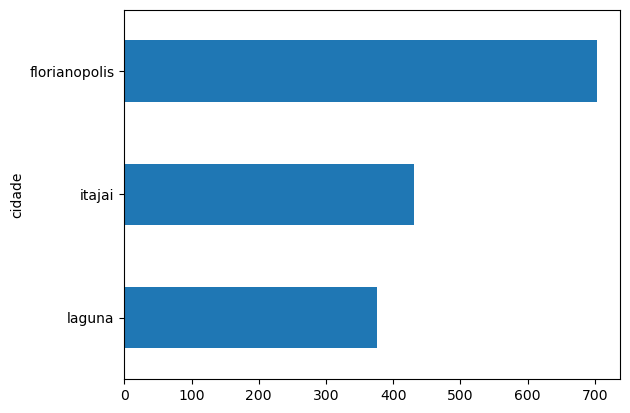

In [52]:
alertas_por_cidade = df_enriquecido.query(query).groupby(['cidade']).size().sort_values()

alertas_por_cidade.plot.barh()

Quantiade de alertas por hora do dia. Observa-se a maior incidência de alertas nos períodos da manhã (09h) e noite (19h).

<AxesSubplot:xlabel='hora'>

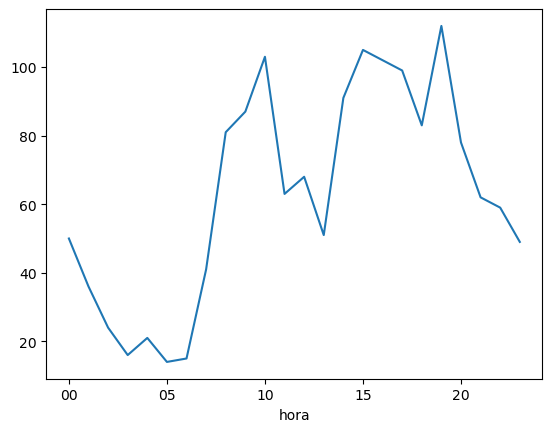

In [53]:
alertas_por_horario = df_enriquecido.query(query).groupby(['hora']).size()

alertas_por_horario.plot.line()

Quantidade de alertas por mês do ano. A maior parte dos alertas foram gerados durante o verão e o início da primavera.

<AxesSubplot:xlabel='mes'>

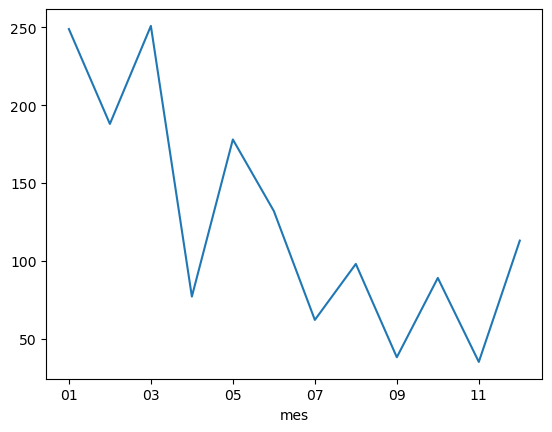

In [54]:
alertas_por_mes = df_enriquecido.copy()

alertas_por_mes['mes'] = alertas_por_mes['data'].str.slice(5, 7)

alertas_por_mes = alertas_por_mes.query(query).groupby(['mes']).size()

alertas_por_mes.plot.line()

Boxplot da coluna de precipitação nos dias onde houveram alertas. O gráfico mostra que a grande maioria dos dias teve medições baixas ou zeradas de chuva.

<AxesSubplot:>

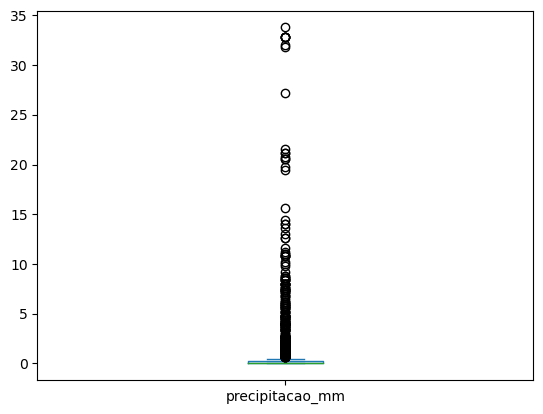

In [55]:
df_enriquecido.query(query)['precipitacao_mm'].plot.box()

Boxplot da coluna de temperatura do ar. Temperaturas dentro da média com poucos outliers, se comparado à coluna de precipitação.

<AxesSubplot:>

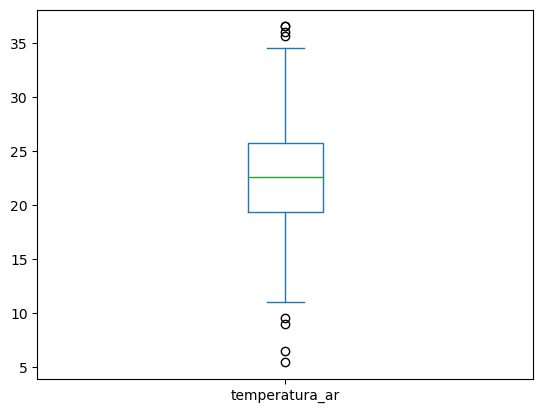

In [56]:
df_enriquecido.query(query)['temperatura_ar'].plot.box()

Boxplot da coluna de rajada máxima do vento. Muitos valores considerados outliers, indicando dias com medições de ventos com velocidades fora da normalidade.

<AxesSubplot:>

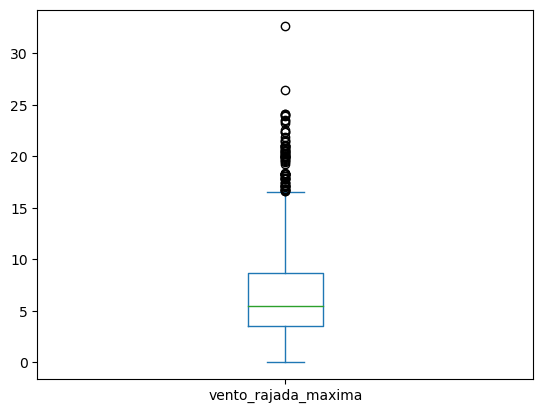

In [57]:
df_enriquecido.query(query)['vento_rajada_maxima'].plot.box()

Histogramas de cada atributo da tabela.

array([[<AxesSubplot:title={'center':'precipitacao_mm'}>,
        <AxesSubplot:title={'center':'pressao_atm'}>,
        <AxesSubplot:title={'center':'temperatura_ar'}>],
       [<AxesSubplot:title={'center':'umidade_ar'}>,
        <AxesSubplot:title={'center':'vento_rajada_maxima'}>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

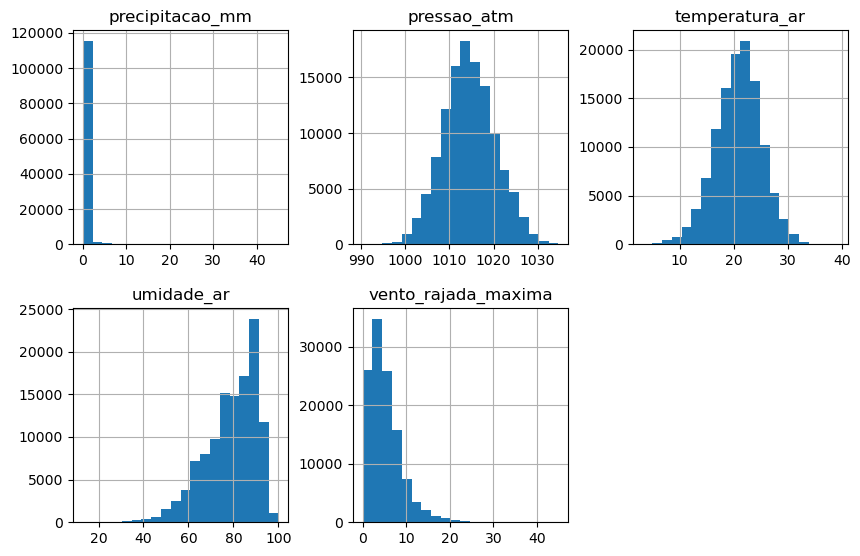

In [58]:
df_enriquecido.hist(bins=20, layout=(3, 3), figsize=(10, 10))

# 3. Criação de modelos de machine learning

In [59]:
df_modelo = df_enriquecido.copy()

df_modelo['precipitacao_mm_acm_24h']       = df_modelo['precipitacao_mm'].rolling(24).sum()
df_modelo['precipitacao_mm_media_24h']     = df_modelo['precipitacao_mm'].rolling(24).mean()
df_modelo['pressao_atm_media_24h']         = df_modelo['pressao_atm'].rolling(24).mean()
df_modelo['temperatura_ar_media_24h']      = df_modelo['temperatura_ar'].rolling(24).mean()
df_modelo['umidade_ar_media_24h']          = df_modelo['umidade_ar'].rolling(24).mean()
df_modelo['vento_rajada_maxima_media_24h'] = df_modelo['vento_rajada_maxima'].rolling(24).mean()
df_modelo['mes']                           = df_modelo['data'].str.slice(5, 7)

df_modelo = df_modelo.drop(columns=['data', 'cidade'])

df_modelo.dropna(inplace=True)

df_modelo

,precipitacao_mm,pressao_atm,temperatura_ar,umidade_ar,vento_rajada_maxima,hora,tipo_alerta,alerta_desastre,precipitacao_mm_acm_24h,precipitacao_mm_media_24h,pressao_atm_media_24h,temperatura_ar_media_24h,umidade_ar_media_24h,vento_rajada_maxima_media_24h,mes
23,0.0,1009.1,25.0,85.0,2.3,23,SEM REGISTRO,False,14.8,0.616667,1008.512500,26.125000,77.666667,5.700000,01
24,0.0,1010.1,24.9,84.0,2.4,00,SEM REGISTRO,False,13.4,0.558333,1008.475000,26.183333,77.458333,5.470833,01
25,0.0,1010.7,24.3,87.0,2.8,01,SEM REGISTRO,False,11.6,0.483333,1008.445833,26.229167,77.291667,5.295833,01
26,0.0,1010.6,24.3,86.0,2.8,02,SEM REGISTRO,False,10.8,0.450000,1008.466667,26.262500,77.125000,5.200000,01
27,0.0,1010.2,24.4,85.0,2.1,03,SEM REGISTRO,False,10.8,0.450000,1008.495833,26.312500,76.958333,5.133333,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128920,0.0,1008.7,21.9,74.0,9.2,19,VENDAVAL,True,6.2,0.258333,1005.579167,21.866667,83.000000,4.475000,10
128921,0.0,1009.6,21.4,69.0,9.2,20,SEM REGISTRO,False,6.2,0.258333,1005.916667,21.658333,83.166667,4.704167,10
128922,0.0,1011.3,21.0,67.0,8.4,21,SEM REGISTRO,False,6.2,0.258333,1006.308333,21.475000,83.125000,4.895833,10
128923,0.0,1013.0,20.6,66.0,10.4,22,SEM REGISTRO,False,3.4,0.141667,1006.675000,21.404167,82.625000,4.645833,10


É feito o upsample do dataset para que todos os tipos de alertas tenham a mesma quantidade de linhas.

In [60]:
df_modelo_false = df_modelo[df_modelo['alerta_desastre'] == False]
df_modelo_true = resample(df_modelo[df_modelo['alerta_desastre'] == True], replace=True, n_samples=115086, random_state=25)

In [61]:
lista_dfs = [df_modelo_false, df_modelo_true]
    
df_upsampled = pd.concat(lista_dfs)

df_upsampled

,precipitacao_mm,pressao_atm,temperatura_ar,umidade_ar,vento_rajada_maxima,hora,tipo_alerta,alerta_desastre,precipitacao_mm_acm_24h,precipitacao_mm_media_24h,pressao_atm_media_24h,temperatura_ar_media_24h,umidade_ar_media_24h,vento_rajada_maxima_media_24h,mes
23,0.0,1009.1,25.0,85.0,2.3,23,SEM REGISTRO,False,1.480000e+01,0.616667,1008.512500,26.125000,77.666667,5.700000,01
24,0.0,1010.1,24.9,84.0,2.4,00,SEM REGISTRO,False,1.340000e+01,0.558333,1008.475000,26.183333,77.458333,5.470833,01
25,0.0,1010.7,24.3,87.0,2.8,01,SEM REGISTRO,False,1.160000e+01,0.483333,1008.445833,26.229167,77.291667,5.295833,01
26,0.0,1010.6,24.3,86.0,2.8,02,SEM REGISTRO,False,1.080000e+01,0.450000,1008.466667,26.262500,77.125000,5.200000,01
27,0.0,1010.2,24.4,85.0,2.1,03,SEM REGISTRO,False,1.080000e+01,0.450000,1008.495833,26.312500,76.958333,5.133333,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26397,0.0,1016.8,22.2,87.0,2.9,09,CHUVAS INTENSAS,True,2.000000e-01,0.008333,1017.004167,24.941667,74.500000,5.095833,02
69621,0.0,1005.9,29.0,63.0,5.4,14,CHUVAS INTENSAS,True,-7.993606e-15,0.000000,1004.962500,26.625000,73.458333,7.395833,03
17987,0.0,1010.6,29.0,72.0,7.5,16,CHUVAS INTENSAS,True,2.000000e+00,0.083333,1010.233333,26.895833,76.500000,4.908333,01
63153,11.6,1003.3,18.2,87.0,16.7,09,CHUVAS INTENSAS,True,1.180000e+01,0.491667,1001.383333,21.166667,76.583333,14.104167,06


A função abaixo aplicará o modelo de machine learning, separando os dados entre treinamento e testes e também medindo a performance do modelo.

In [62]:
DataFrame = pd.core.frame.DataFrame

def aplicar_ml(tipo_modelo, df: DataFrame, col_x: list, col_y: str):
    
    global model_name
    global model
    global x_train
    global x_test
    global y_train
    global y_test
    global predict
        
    df_x = df[col_x]
    df_y = df[col_y]

    x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.1)
    
    model_name = tipo_modelo
    model = model_name.fit(x_train, y_train)

    # acurácia
    acuracia = model.score(x_train, y_train)
    print("Acurácia: ", acuracia)

    # previsão
    predict = model.predict(x_test)
    score = accuracy_score(y_test, predict)
    print("\nTaxa de previsão: ", score)

    # erros de classificação
    acertos = (y_test != predict).sum()
    registros = df_upsampled.count()[0]
    print("\nErros de classificação: {0} de {1}".format(acertos, registros))

    print("\nMétricas de classificação:")
    print(classification_report(y_test, predict))

In [63]:
df    = df_upsampled
col_x = ['precipitacao_mm', 'pressao_atm', 'temperatura_ar', 'umidade_ar', 'vento_rajada_maxima', 'precipitacao_mm_acm_24h', 
         'precipitacao_mm_media_24h', 'pressao_atm_media_24h', 'temperatura_ar_media_24h', 'umidade_ar_media_24h', 
         'vento_rajada_maxima_media_24h', 'mes', 'hora']
col_y = 'alerta_desastre'

## 3.1. Árvore de decisão

O primeiro modelo utilizado é a árvore de decisão. O modelo foi configurado para 'descer' até cinco níveis para evitar overfitting.

Foi observada acurácia de 91%. O resultado da validação cruzada também foi de 91%. A precisão para prever a presença (91%) ou ausência (88%) de alertas de desastre foi satisfatória.

In [64]:
aplicar_ml(DecisionTreeClassifier(max_depth=5), df=df, col_x=col_x, col_y=col_y)

Acurácia:  0.7346034091508786

Taxa de previsão:  0.7323402417962004

Erros de classificação: 6199 de 231599

Métricas de classificação:
              precision    recall  f1-score   support

       False       0.82      0.60      0.69     11658
        True       0.68      0.86      0.76     11502

    accuracy                           0.73     23160
   macro avg       0.75      0.73      0.73     23160
weighted avg       0.75      0.73      0.73     23160



In [65]:
cross_validation = cross_validate(model_name, x_train, y_train, cv=10, return_estimator=True)

cross_validation['test_score'].mean()

0.7335287500865574

In [66]:
tree_txt = tree.export_text(model, feature_names=col_x)

print(tree_txt)

|--- precipitacao_mm_media_24h <= 0.13
|   |--- pressao_atm <= 1014.35
|   |   |--- hora <= 7.50
|   |   |   |--- vento_rajada_maxima <= 2.75
|   |   |   |   |--- pressao_atm <= 1003.75
|   |   |   |   |   |--- class: False
|   |   |   |   |--- pressao_atm >  1003.75
|   |   |   |   |   |--- class: False
|   |   |   |--- vento_rajada_maxima >  2.75
|   |   |   |   |--- hora <= 0.50
|   |   |   |   |   |--- class: True
|   |   |   |   |--- hora >  0.50
|   |   |   |   |   |--- class: False
|   |   |--- hora >  7.50
|   |   |   |--- pressao_atm <= 1009.15
|   |   |   |   |--- temperatura_ar <= 26.95
|   |   |   |   |   |--- class: True
|   |   |   |   |--- temperatura_ar >  26.95
|   |   |   |   |   |--- class: True
|   |   |   |--- pressao_atm >  1009.15
|   |   |   |   |--- vento_rajada_maxima_media_24h <= 2.37
|   |   |   |   |   |--- class: False
|   |   |   |   |--- vento_rajada_maxima_media_24h >  2.37
|   |   |   |   |   |--- class: True
|   |--- pressao_atm >  1014.35
|   |   |--

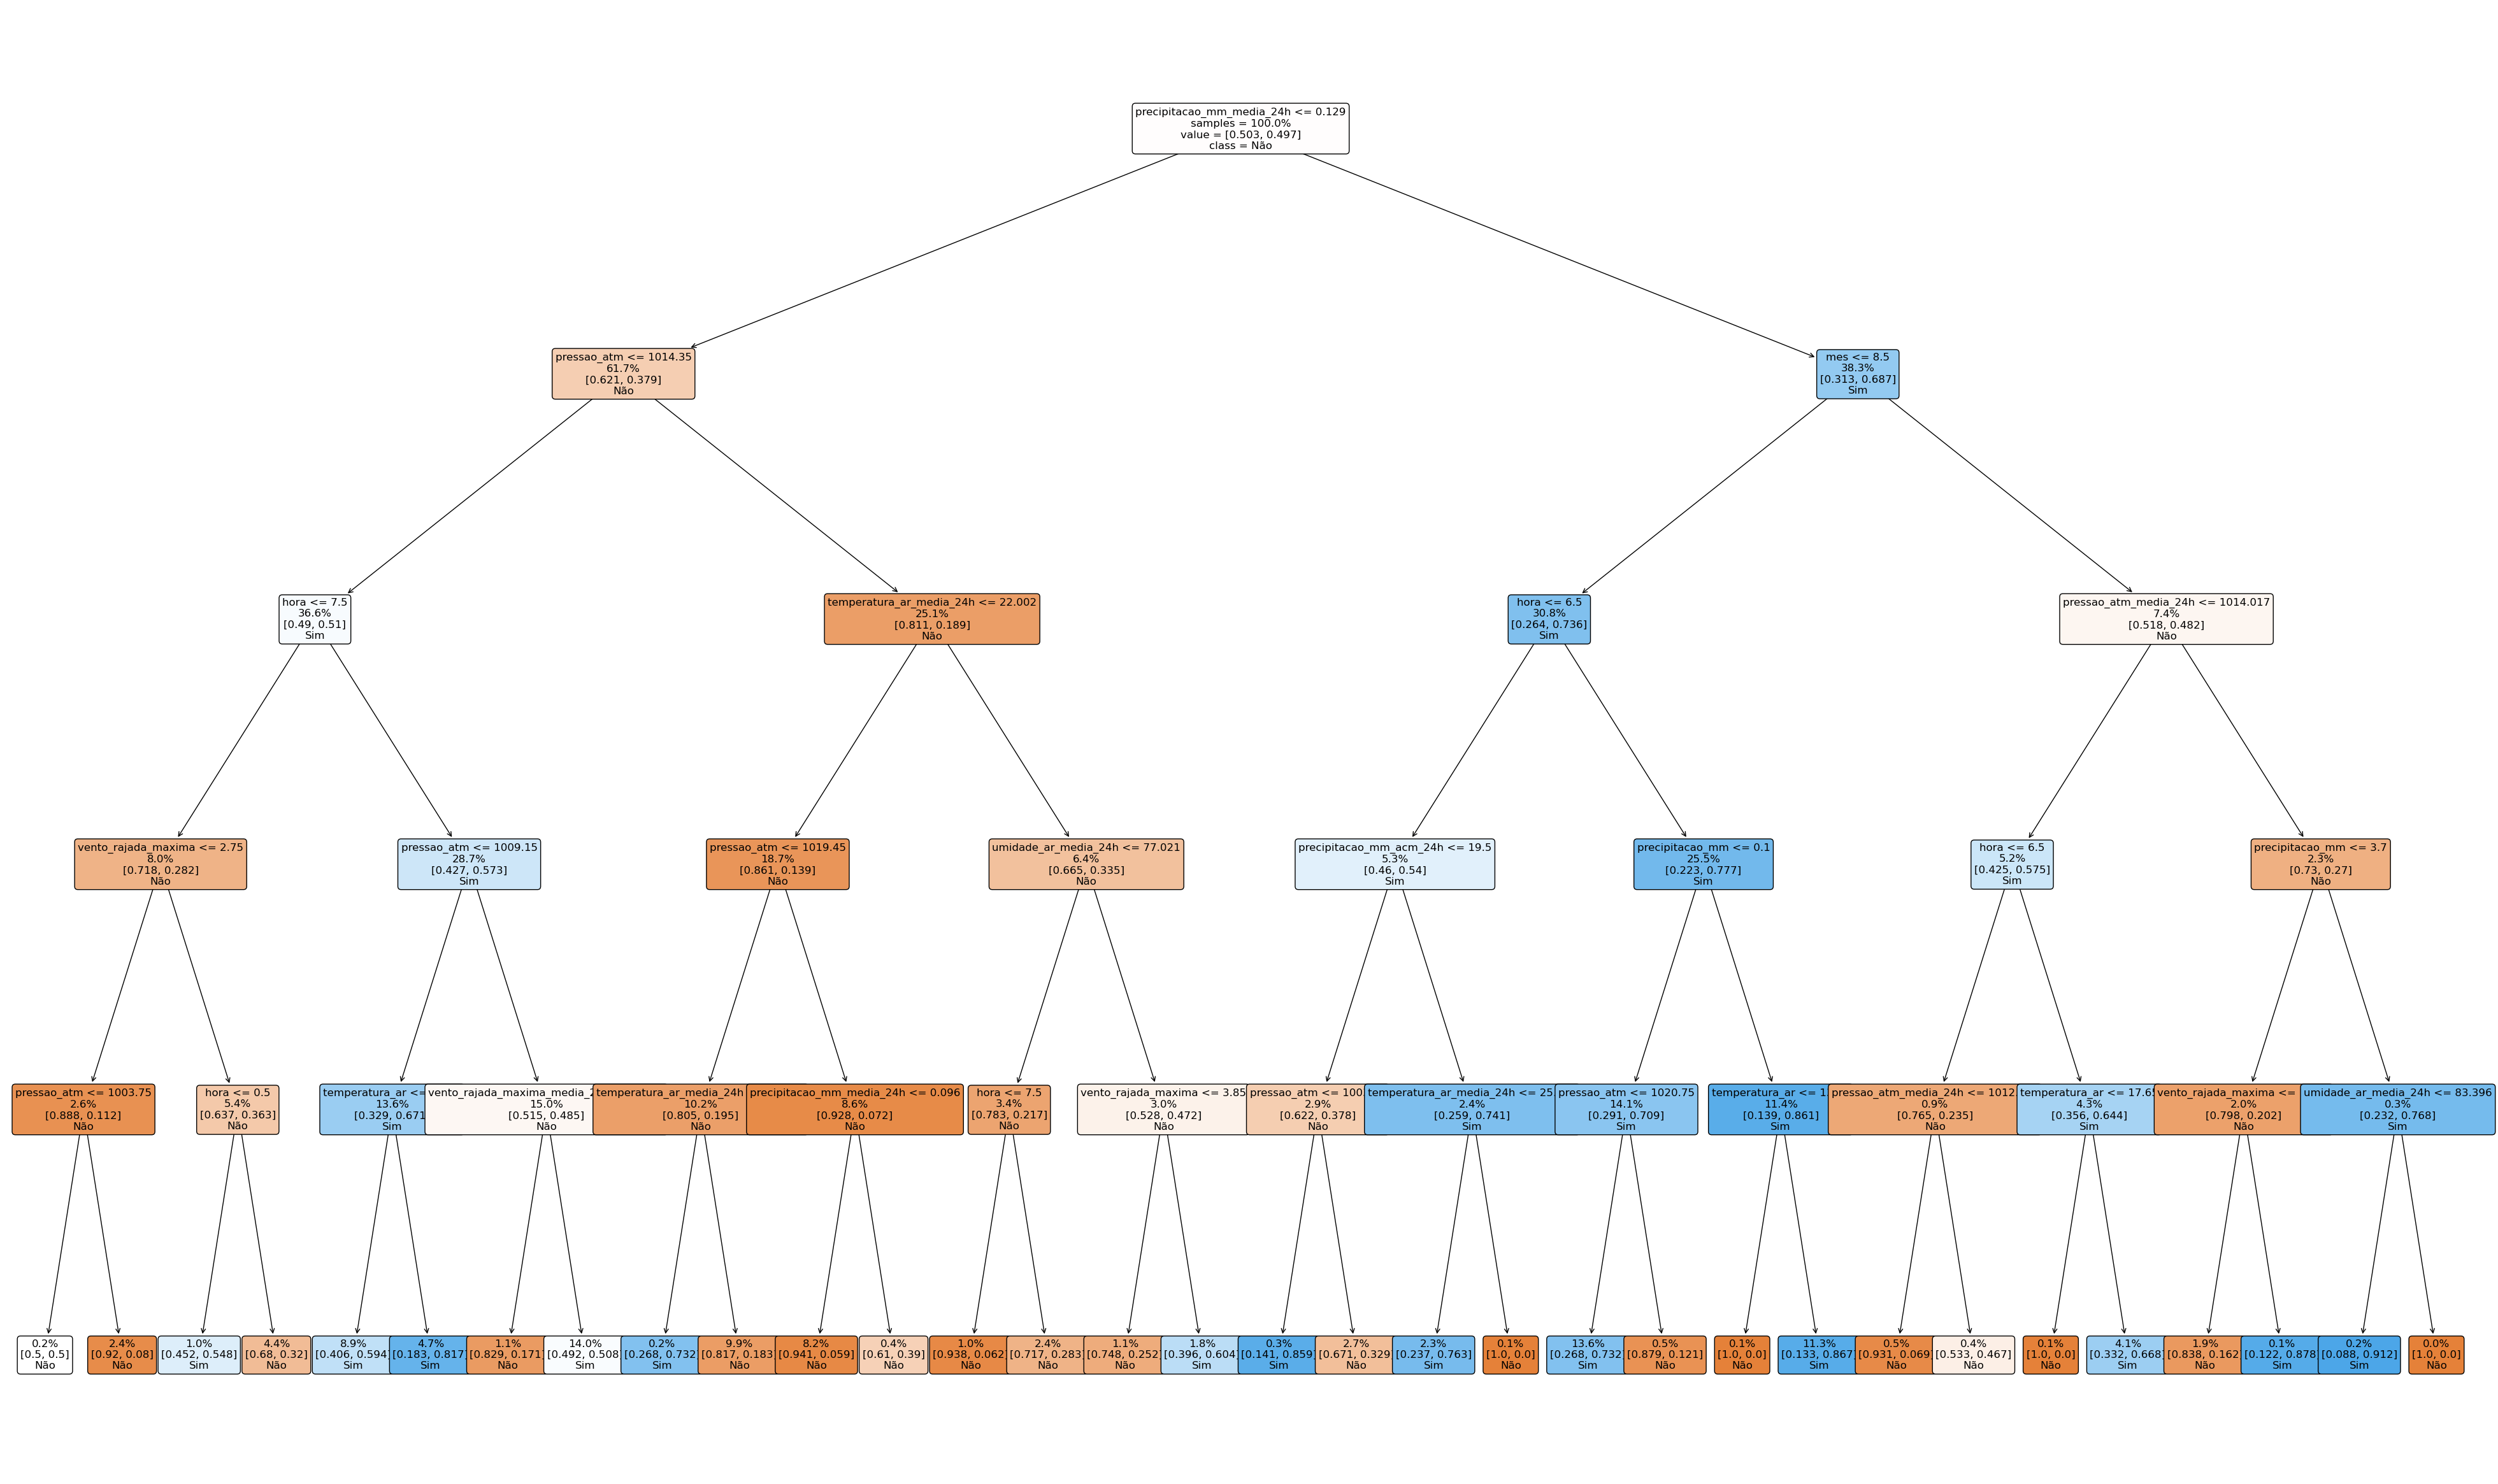

In [67]:
class_names = ['Não', 'Sim']

fig = plt.figure(figsize=(50,30))

_ = tree.plot_tree(decision_tree=model,
                   max_depth=5,
                   feature_names=col_x,
                   class_names=class_names,
                   label='root',
                   filled=True,
                   impurity=False,
                   proportion=True,
                   rounded=True,
                   fontsize=12)

## 3.2. Regressão logística

O segundo modelo utilizado foi o de regressão logística.

É o modelo que melhor obteve notas de acurácia geral (98%) e validação cruzada (também 98%), porém a precisão para medir valores True, ou seja, condições climáticas que poderiam gerar um alerta de desastre, foi de apenas 14%. A precisão para prever condições sem alertas de desastre foi de 99%. O modelo funcionou bem para prever quando não haveriam desastres, o que é, de certa forma, o objetivo contrário do trabalho.

In [70]:
aplicar_ml(LogisticRegression(), df=df, col_x=col_x, col_y=col_y)

C:\Users\renan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Acurácia:  0.689587841047021

Taxa de previsão:  0.6843264248704664

Erros de classificação: 7311 de 231599

Métricas de classificação:
              precision    recall  f1-score   support

       False       0.67      0.72      0.70     11650
        True       0.70      0.65      0.67     11510

    accuracy                           0.68     23160
   macro avg       0.69      0.68      0.68     23160
weighted avg       0.69      0.68      0.68     23160



In [73]:
cross_validation = cross_validate(model_name, x_train, y_train, cv=10, return_estimator=True)

cross_validation['test_score'].mean()

C:\Users\renan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\renan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

0.6888874054091175

In [71]:
cnf_matrix = confusion_matrix(y_test, predict)

cnf_matrix

array([[8425, 3225],
       [4086, 7424]], dtype=int64)

<AxesSubplot:>

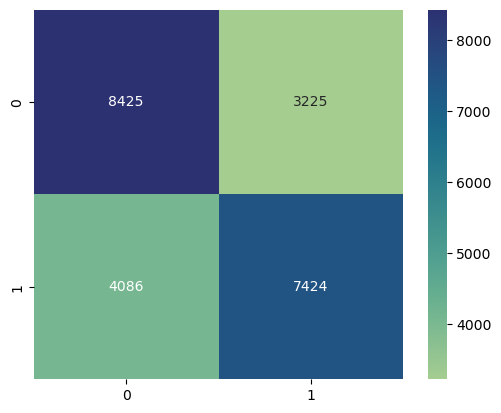

In [72]:
sns.heatmap(cnf_matrix, annot=True, cmap="crest", square=True, fmt='g')

## 3.3. Naive Bayes

In [74]:
aplicar_ml(GaussianNB(), df=df, col_x=col_x, col_y=col_y)

Acurácia:  0.6165304957325645

Taxa de previsão:  0.6233160621761658

Erros de classificação: 8724 de 231599

Métricas de classificação:
              precision    recall  f1-score   support

       False       0.58      0.91      0.71     11858
        True       0.78      0.32      0.45     11302

    accuracy                           0.62     23160
   macro avg       0.68      0.62      0.58     23160
weighted avg       0.68      0.62      0.59     23160



In [75]:
cross_validation = cross_validate(model_name, x_train, y_train, cv=10, return_estimator=True)

cross_validation['test_score'].mean()

0.6166648294074681

Acurácia:  0.5924227231947956

Taxa de previsão:  0.5946891191709844

Erros de classificação: 9387 de 231599

Métricas de classificação:
              precision    recall  f1-score   support

       False       0.56      0.93      0.70     11700
        True       0.78      0.25      0.38     11460

    accuracy                           0.59     23160
   macro avg       0.67      0.59      0.54     23160
weighted avg       0.67      0.59      0.54     23160



C:\Users\renan\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


<AxesSubplot:>

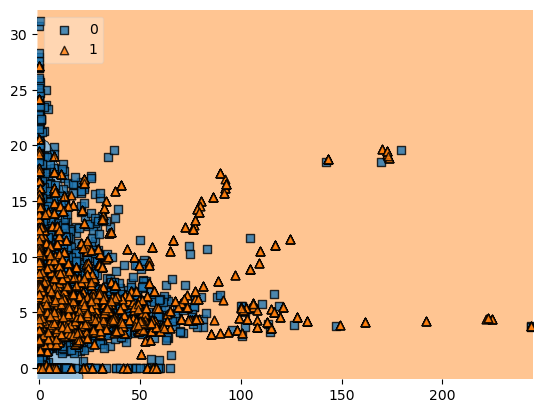

In [83]:
col_x = ['precipitacao_mm_acm_24h', 'vento_rajada_maxima_media_24h']

aplicar_ml(GaussianNB(), df=df, col_x=col_x, col_y=col_y)

# gráfico
plot_decision_regions(x_test.values, y_test.astype(np.int_).values, clf = model, legend = 2)

## 3.4. Random Forest

In [78]:
aplicar_ml(RandomForestClassifier(), df=df, col_x=col_x, col_y=col_y)

Acurácia:  0.7375635077888495

Taxa de previsão:  0.7386873920552677

Erros de classificação: 6052 de 231599

Métricas de classificação:
              precision    recall  f1-score   support

       False       0.73      0.76      0.74     11612
        True       0.75      0.72      0.73     11548

    accuracy                           0.74     23160
   macro avg       0.74      0.74      0.74     23160
weighted avg       0.74      0.74      0.74     23160



In [80]:
aplicar_ml(RandomForestClassifier(), df=df, col_x=col_x, col_y=col_y)

Acurácia:  0.7375011394220852

Taxa de previsão:  0.7393782383419689

Erros de classificação: 6036 de 231599

Métricas de classificação:
              precision    recall  f1-score   support

       False       0.74      0.74      0.74     11604
        True       0.74      0.74      0.74     11556

    accuracy                           0.74     23160
   macro avg       0.74      0.74      0.74     23160
weighted avg       0.74      0.74      0.74     23160

